In [1]:
# Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
trnsc=pd.read_excel("QVI_transaction_data.xlsx")
trnsc.info()
# No null values

(264836, 8)

In [5]:
trnsc.describe()
# No anamolies

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264836.000000,264836.00000,2.648360e+05,2.648360e+05,264836.000000,264836.000000,264836.000000
mean,43464.036260,135.08011,1.355495e+05,1.351583e+05,56.583157,1.907309,7.304200
std,105.389282,76.78418,8.057998e+04,7.813303e+04,32.826638,0.643654,3.083226
min,43282.000000,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,43373.000000,70.00000,7.002100e+04,6.760150e+04,28.000000,2.000000,5.400000
50%,43464.000000,130.00000,1.303575e+05,1.351375e+05,56.000000,2.000000,7.400000
75%,43555.000000,203.00000,2.030942e+05,2.027012e+05,85.000000,2.000000,9.200000
max,43646.000000,272.00000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


#### "PROD_NBR" == "PROD_NAME"
#### Convert the Date column into Date type Variable
#### Do some modifications on "PROD_NAME"
#### seperate package size from the name
#### seperate company from the "PROD_NAME"
#### why is "TOT_SALES"  column in decimal?? is it representing % then why is the max value 650

In [7]:
transc=trnsc.copy()
import re
packages=transc["PROD_NAME"].apply(lambda x:x.split()[-1])
packages

0         SeaSalt175g
1                175g
2                170g
3                175g
4                150g
             ...     
264831           175g
264832           175g
264833           170g
264834           150g
264835           175g
Name: PROD_NAME, Length: 264836, dtype: object

In [8]:
packages=np.where(packages=='Salt',"135g",packages)
packages=pd.Series(packages)
packages.unique()

array(['SeaSalt175g', '175g', '170g', '150g', '300g', '330g', '210g',
       '210G', '270g', '220g', '125g', '110g', '134g', '150G',
       'Chli&S/Cream175G', 'Chckn175g', '380g', 'Chicken270g', '180g',
       '165g', '135g', '250g', 'Ht300g', 'Chs&Onion170g', '200g', '160g',
       'CutSalt/Vinegr175g', '190g', '90g', '70g'], dtype=object)

#### SeaSalt175g
#### Chli&S/Cream175G
#### Chckn175g
#### Chicken270g
#### Chs&Onion170g
#### Ht300g
#### CutSalt/Vinegr175g

In [9]:
packages=packages.apply(lambda x:x[-4:].split('g')[0])
# adding new colum to "transc"
transc["Pkg_size_grm"]=packages

# Removing the numbers from the names of chips
transc["PROD_NAME"]=transc["PROD_NAME"].apply(lambda x:x[:-4])
transc["PROD_NAME"]=np.where(transc["PROD_NAME"]=='Kettle 135g Swt Pot Sea ','Kettle Swt Pot Sea Salt',transc["PROD_NAME"])

#Converting into Lower case letters
transc["PROD_NAME"]=transc["PROD_NAME"].apply(lambda x:x.lower())

# Coverting the DATE column to the desired format
date_offsets = transc["DATE"]
base_date = pd.Timestamp('1899-12-30')  # check this!
dates = pd.Series([
    base_date + pd.DateOffset(date_offset) 
    for date_offset in date_offsets
])
transc["DATE"]=dates

In [11]:
transc["Pkg_size_grm"].unique()

array(['175', '170', '150', '300', '330', '210', '210G', '270', '220',
       '125', '110', '134', '150G', '175G', '380', '180', '165', '135',
       '250', '200', '160', '190', '90', '70'], dtype=object)

In [12]:
def cleaning(a):
    if len(a)>3:
        return a[:-1]
    else:
        return a
    
transc["Pkg_size_grm"]=transc["Pkg_size_grm"].apply(cleaning)

In [13]:
transc["Pkg_size_grm"]

0         175
1         175
2         170
3         175
4         150
         ... 
264831    175
264832    175
264833    170
264834    150
264835    175
Name: Pkg_size_grm, Length: 264836, dtype: object

In [14]:
convert_dict={"Pkg_size_grm":int}
transc=transc.astype(convert_dict)
transc.describe()

In [16]:
# The MAX of "PROD_QTY" is 200!
# Let us examine this outlier
transc[transc["PROD_QTY"]==200]

# The same customer bought 200 chips twice for the same kind of chips

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme,200,650.0,380


In [17]:
# lets see if this customer has any other transactions
transc[transc["LYLTY_CARD_NBR"]==226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm
69762,2018-08-19,226,226000,226201,4,dorito corn chp supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,dorito corn chp supreme,200,650.0,380


It looks like this customer has only had the two transactions over the year and is
not an ordinary retail customer. The customer might be buying chips for commercial
purposes instead. We'll remove this loyalty card number from further analysis.

In [18]:
transc.drop(index=list(transc[transc["LYLTY_CARD_NBR"]==226000].index),inplace=True)
transc.shape

(264834, 9)

There's only 364 rows, meaning only 364 dates which indicates a missing date. Let's
create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a
chart of number of transactions over time to find the missing date.

In [19]:
transc[transc["TXN_ID"]==230356]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm
79055,2018-12-07,229,229001,230356,55,snbts whlgrn crisps cheddr&mstrd,2,3.4,90
79056,2018-12-07,229,229001,230356,20,doritos cheese supreme,2,11.4,330
79057,2018-12-07,229,229001,230356,86,cheetos puffs,2,5.6,165


"TXN_ID" column need not be unique

In [20]:
time_series=pd.DataFrame(transc["DATE"].value_counts())
time_series.reset_index(inplace=True)
time_series.columns=["DATE","No_of_TRANSC"]
time_series.sort_values(by=["DATE"],ascending=True,inplace=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

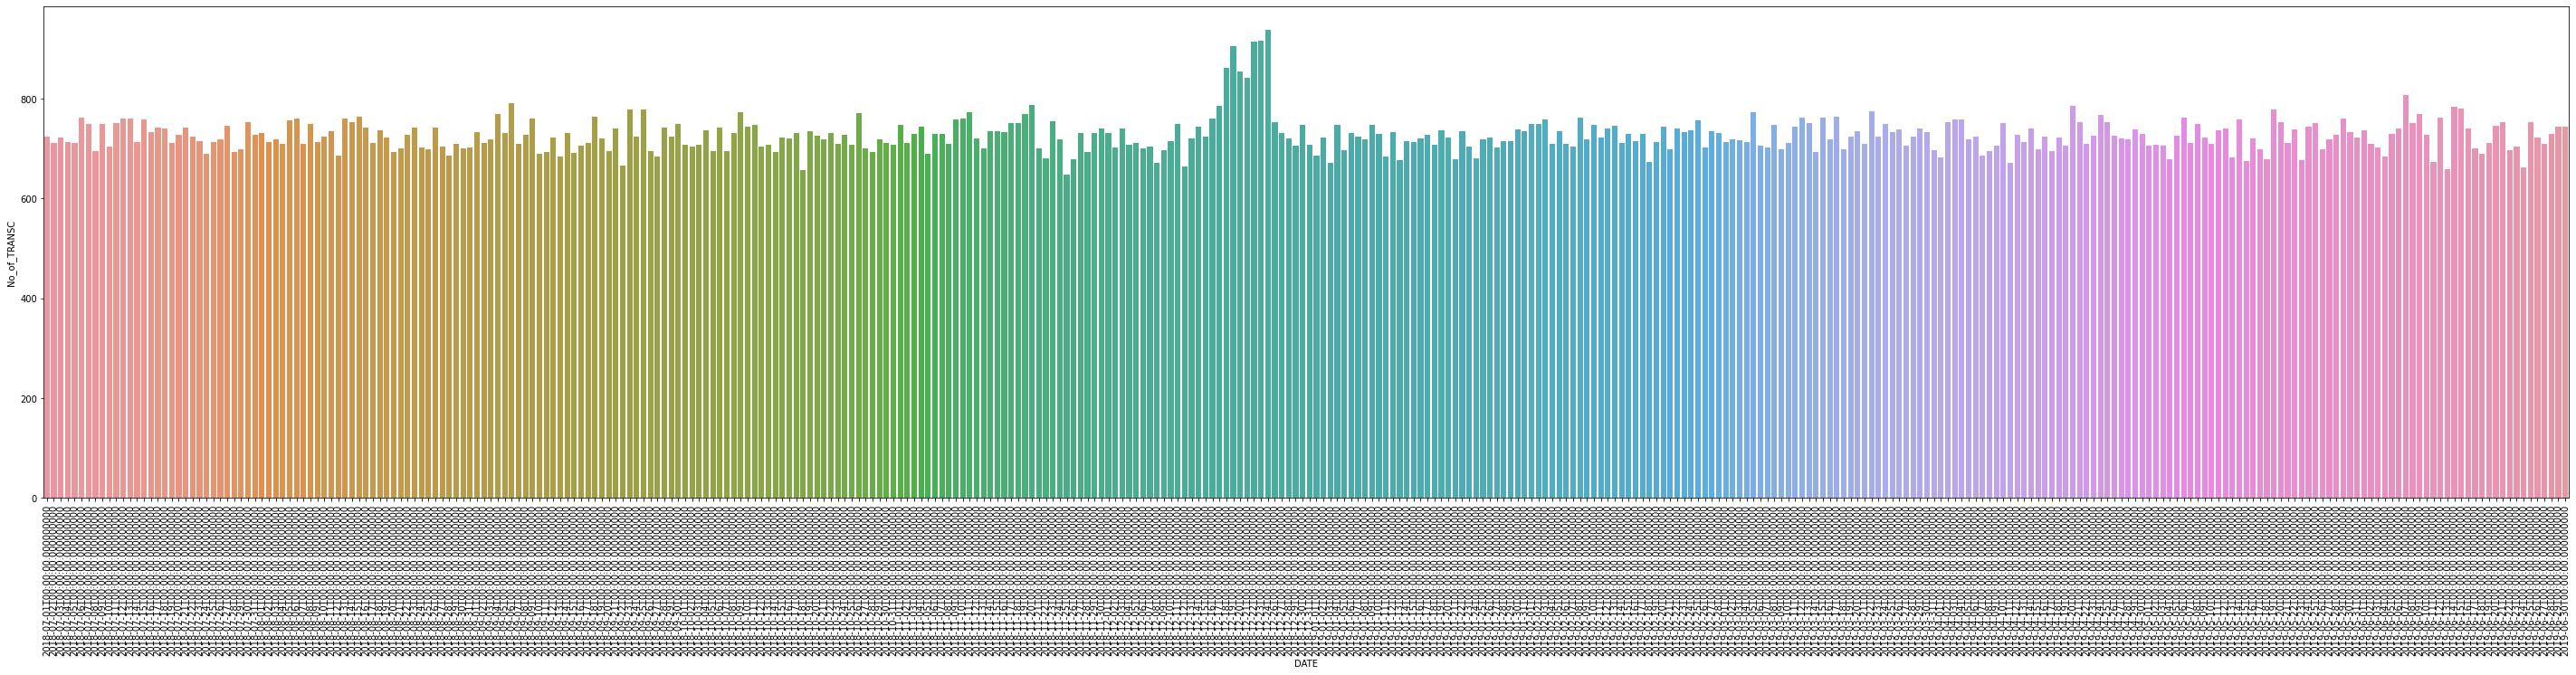

In [21]:
plt.figure(figsize=(50,10))
sns.barplot(x="DATE",y="No_of_TRANSC",data=time_series)
plt.xticks(rotation=90)

The plot is messy but it does that the no.of transactions per day see a spike in the days leading to covid...and during the day of christmas the shops are closed so the transactions are 0..and the spike decreases after the christmas. 

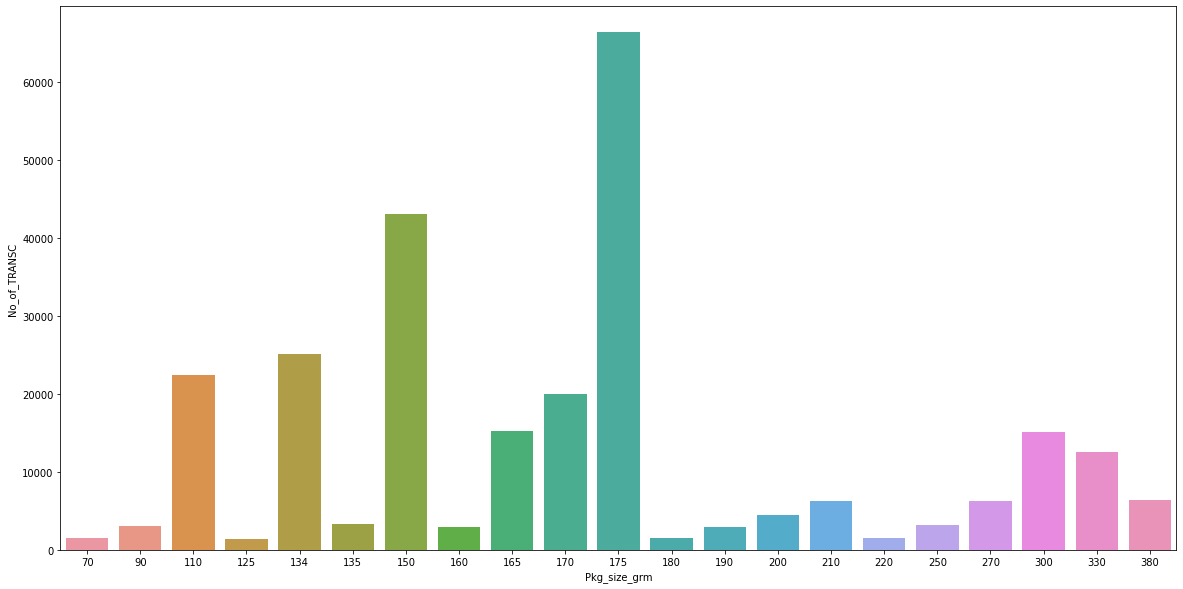

In [22]:
# Pkg_size_grm is a Categorical variable actually encoded in numbers
package_freq=pd.DataFrame(transc["Pkg_size_grm"].value_counts())
package_freq.reset_index(inplace=True)
package_freq.columns={"Pkg_size_grm","No_of_TRANSC"}
package_freq.sort_values(by=["Pkg_size_grm"],ascending=True,inplace=True)

plt.figure(figsize=(20,10))
sns.barplot(x="Pkg_size_grm",y="No_of_TRANSC",data=package_freq)

In [23]:
# Extracting Brand Names
transc["BRAND"]=pd.Series(transc["PROD_NAME"].apply(lambda x:x.split()[0]))
transc

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm,BRAND
0,2018-10-17,1,1000,1,5,natural chip compny seasalt,2,6.0,175,natural
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,175,ccs
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,170,smiths
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion,5,15.0,175,smiths
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili,3,13.8,150,kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream,2,10.8,175,kettle
264832,2018-08-13,272,272358,270154,74,tostitos splash of lime,1,4.4,175,tostitos
264833,2018-11-06,272,272379,270187,51,doritos mexicana,2,8.8,170,doritos
264834,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno,2,7.8,150,doritos


#### transc["BRAND"].unique()
#### infuzions , infzns
#### smith , smiths
#### sunbites , snbts , grnwves , grain
#### red , rrd
#### natural , ncc
#### ww , woolworths
#### old --> old el paso
#### dorito , doritos
#### burger --> burger rings
#### french --> french fries

In [24]:
transc["BRAND"].replace(to_replace=["infzns","smith","snbts","grnwves","grain","rrd","ncc","ww","old","dorito","burger","french"],value=["infuzions","smiths","sunbites","sunbites","sunbites","red","natural","woolworths","old el paso","doritos","burger rings","french fries"],inplace=True)
transc["BRAND"].unique()

array(['natural', 'ccs', 'smiths', 'kettle', 'old el paso', 'sunbites',
       'doritos', 'twisties', 'woolworths', 'thins', 'burger rings',
       'cheezels', 'infuzions', 'red', 'pringles', 'tyrrells', 'cobs',
       'french fries', 'tostitos', 'cheetos'], dtype=object)

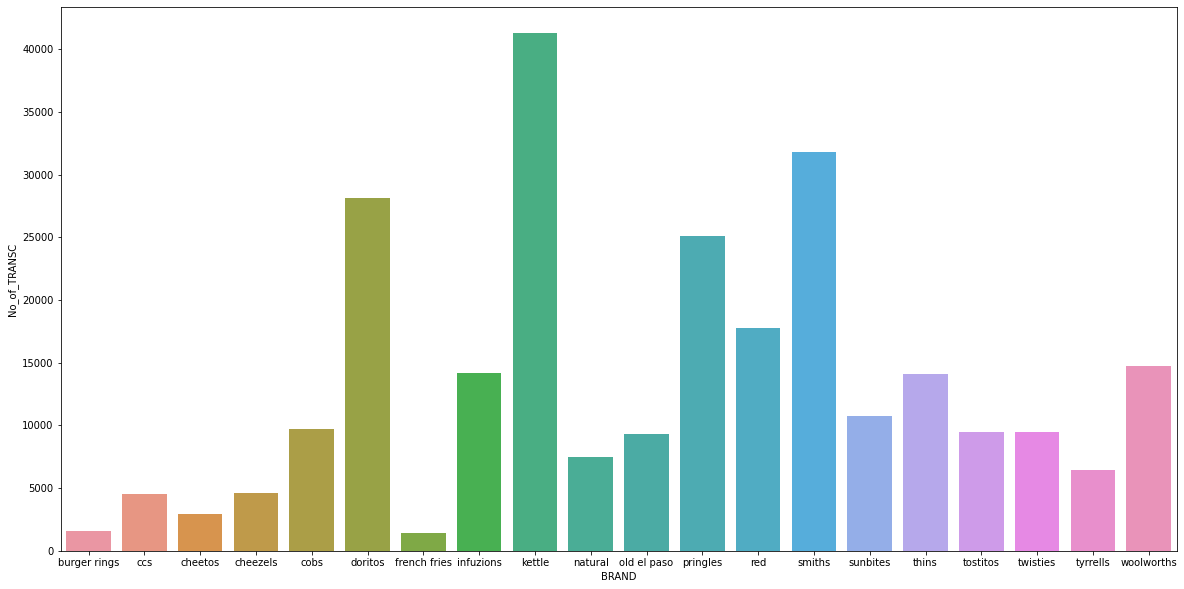

In [25]:
brand_freq=pd.DataFrame(transc["BRAND"].value_counts())
brand_freq.reset_index(inplace=True)
brand_freq.columns=["BRAND","No_of_TRANSC"]
brand_freq.sort_values(by=["BRAND"],ascending=True,inplace=True)

plt.figure(figsize=(20,10))
sns.barplot(x="BRAND",y="No_of_TRANSC",data=brand_freq)

In [26]:
transc["salsa_y_n"]=pd.Series(transc["PROD_NAME"].apply(lambda x: 'salsa' in x))
transc

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm,BRAND,salsa_y_n
0,2018-10-17,1,1000,1,5,natural chip compny seasalt,2,6.0,175,natural,False
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,175,ccs,False
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,170,smiths,False
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion,5,15.0,175,smiths,False
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili,3,13.8,150,kettle,False
...,...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream,2,10.8,175,kettle,False
264832,2018-08-13,272,272358,270154,74,tostitos splash of lime,1,4.4,175,tostitos,False
264833,2018-11-06,272,272379,270187,51,doritos mexicana,2,8.8,170,doritos,False
264834,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno,2,7.8,150,doritos,False


In [27]:
transc[transc["salsa_y_n"]==True]["PROD_NAME"]
# these are not chips
# so we will be deleting them

5         old el paso salsa   dip tomato mild 
25        old el paso salsa   dip tomato mild 
32        red rock deli sr    salsa & mzzrlla 
44           smiths crinkle cut  tomato salsa 
63                 doritos salsa       medium 
                          ...                 
264675     old el paso salsa   dip tomato med 
264678              woolworths mild     salsa 
264719       smiths crinkle cut  tomato salsa 
264734                    doritos salsa mild  
264780    red rock deli sr    salsa & mzzrlla 
Name: PROD_NAME, Length: 18094, dtype: object

In [28]:
transc.drop(index=list(transc[transc["salsa_y_n"]==True].index),inplace=True)
transc.drop(columns="salsa_y_n",inplace=True)
transc

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm,BRAND
0,2018-10-17,1,1000,1,5,natural chip compny seasalt,2,6.0,175,natural
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,175,ccs
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,170,smiths
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion,5,15.0,175,smiths
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili,3,13.8,150,kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream,2,10.8,175,kettle
264832,2018-08-13,272,272358,270154,74,tostitos splash of lime,1,4.4,175,tostitos
264833,2018-11-06,272,272379,270187,51,doritos mexicana,2,8.8,170,doritos
264834,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno,2,7.8,150,doritos


In [29]:
# Analyzing Customer data
cust=pd.read_csv("QVI_purchase_behaviour.csv")
cust.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [30]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
LYLTY_CARD_NBR      72637 non-null int64
LIFESTAGE           72637 non-null object
PREMIUM_CUSTOMER    72637 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [31]:
len(cust["LYLTY_CARD_NBR"].unique())

72637

In [32]:
cust.shape

(72637, 3)

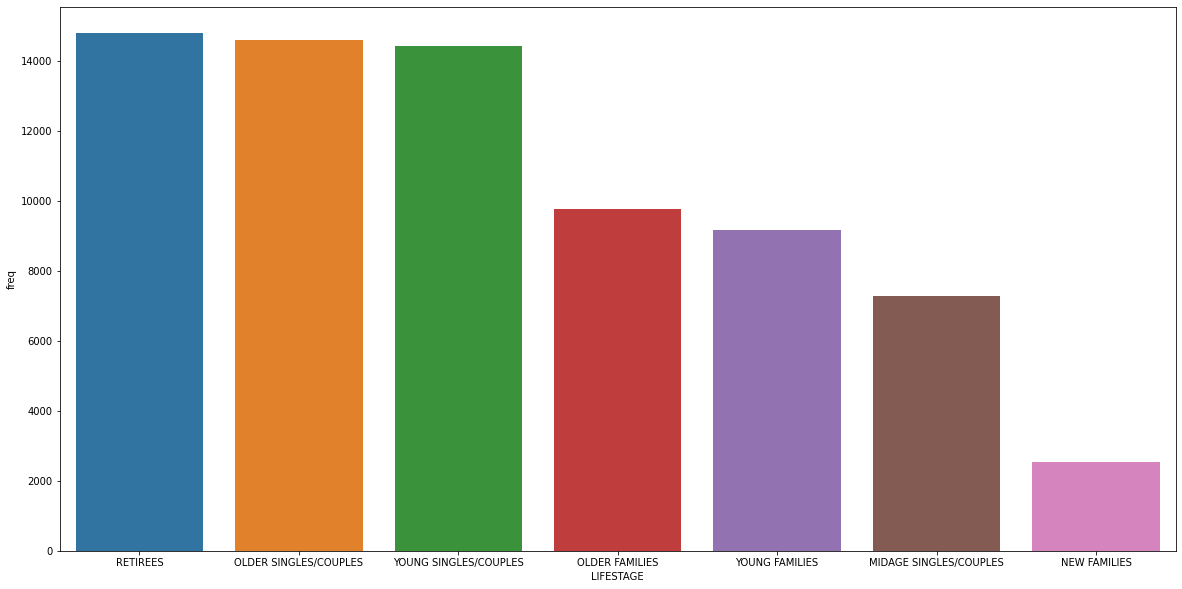

In [33]:
# there seems to be no missing data or descrepencies in the Dataset
lifestage_freq=pd.DataFrame(cust["LIFESTAGE"].value_counts())
lifestage_freq.reset_index(inplace=True)
lifestage_freq.columns=["LIFESTAGE","freq"]

plt.figure(figsize=(20,10))
sns.barplot(x="LIFESTAGE",y="freq",data=lifestage_freq)

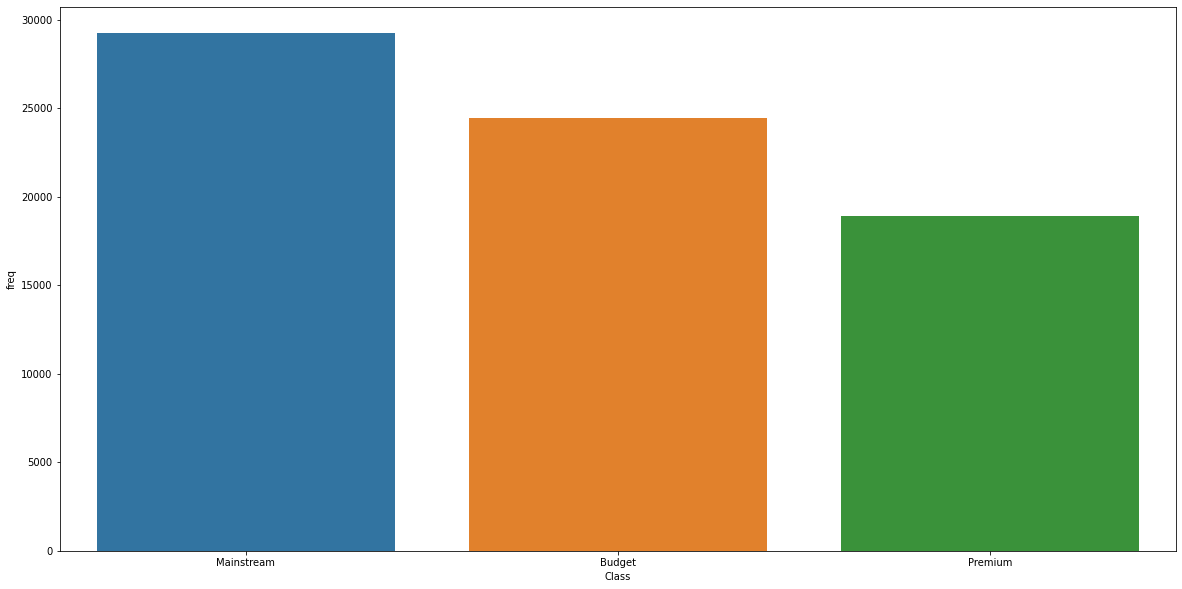

In [34]:
class_cust_freq=pd.DataFrame(cust["PREMIUM_CUSTOMER"].value_counts())
class_cust_freq.reset_index(inplace=True)
class_cust_freq.columns=["Class","freq"]

plt.figure(figsize=(20,10))
sns.barplot(x="Class",y="freq",data=class_cust_freq)

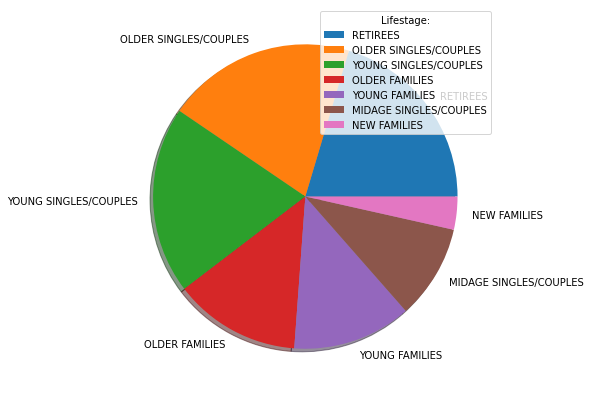

In [35]:
lifesize_freq=pd.DataFrame(cust["LIFESTAGE"].value_counts())
lifesize_freq.columns=["Freq"]

plt.figure(figsize=(7,7))
plt.pie(lifesize_freq["Freq"],labels=lifesize_freq.index,shadow=True)
plt.legend(title="Lifestage:")

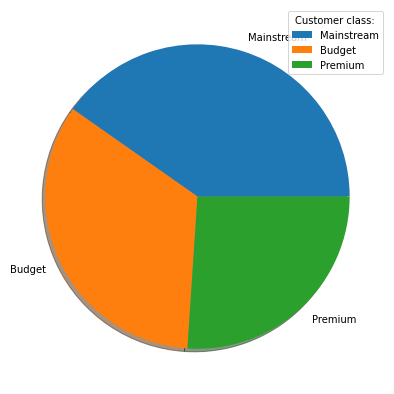

In [36]:
cust_class=pd.DataFrame(cust["PREMIUM_CUSTOMER"].value_counts())
cust_class.columns=["Freq"]

plt.figure(figsize=(7,7))
plt.pie(cust_class["Freq"],labels=cust_class.index,shadow=True)
plt.legend(title="Customer class:")

Text(0, 0.5, 'count')

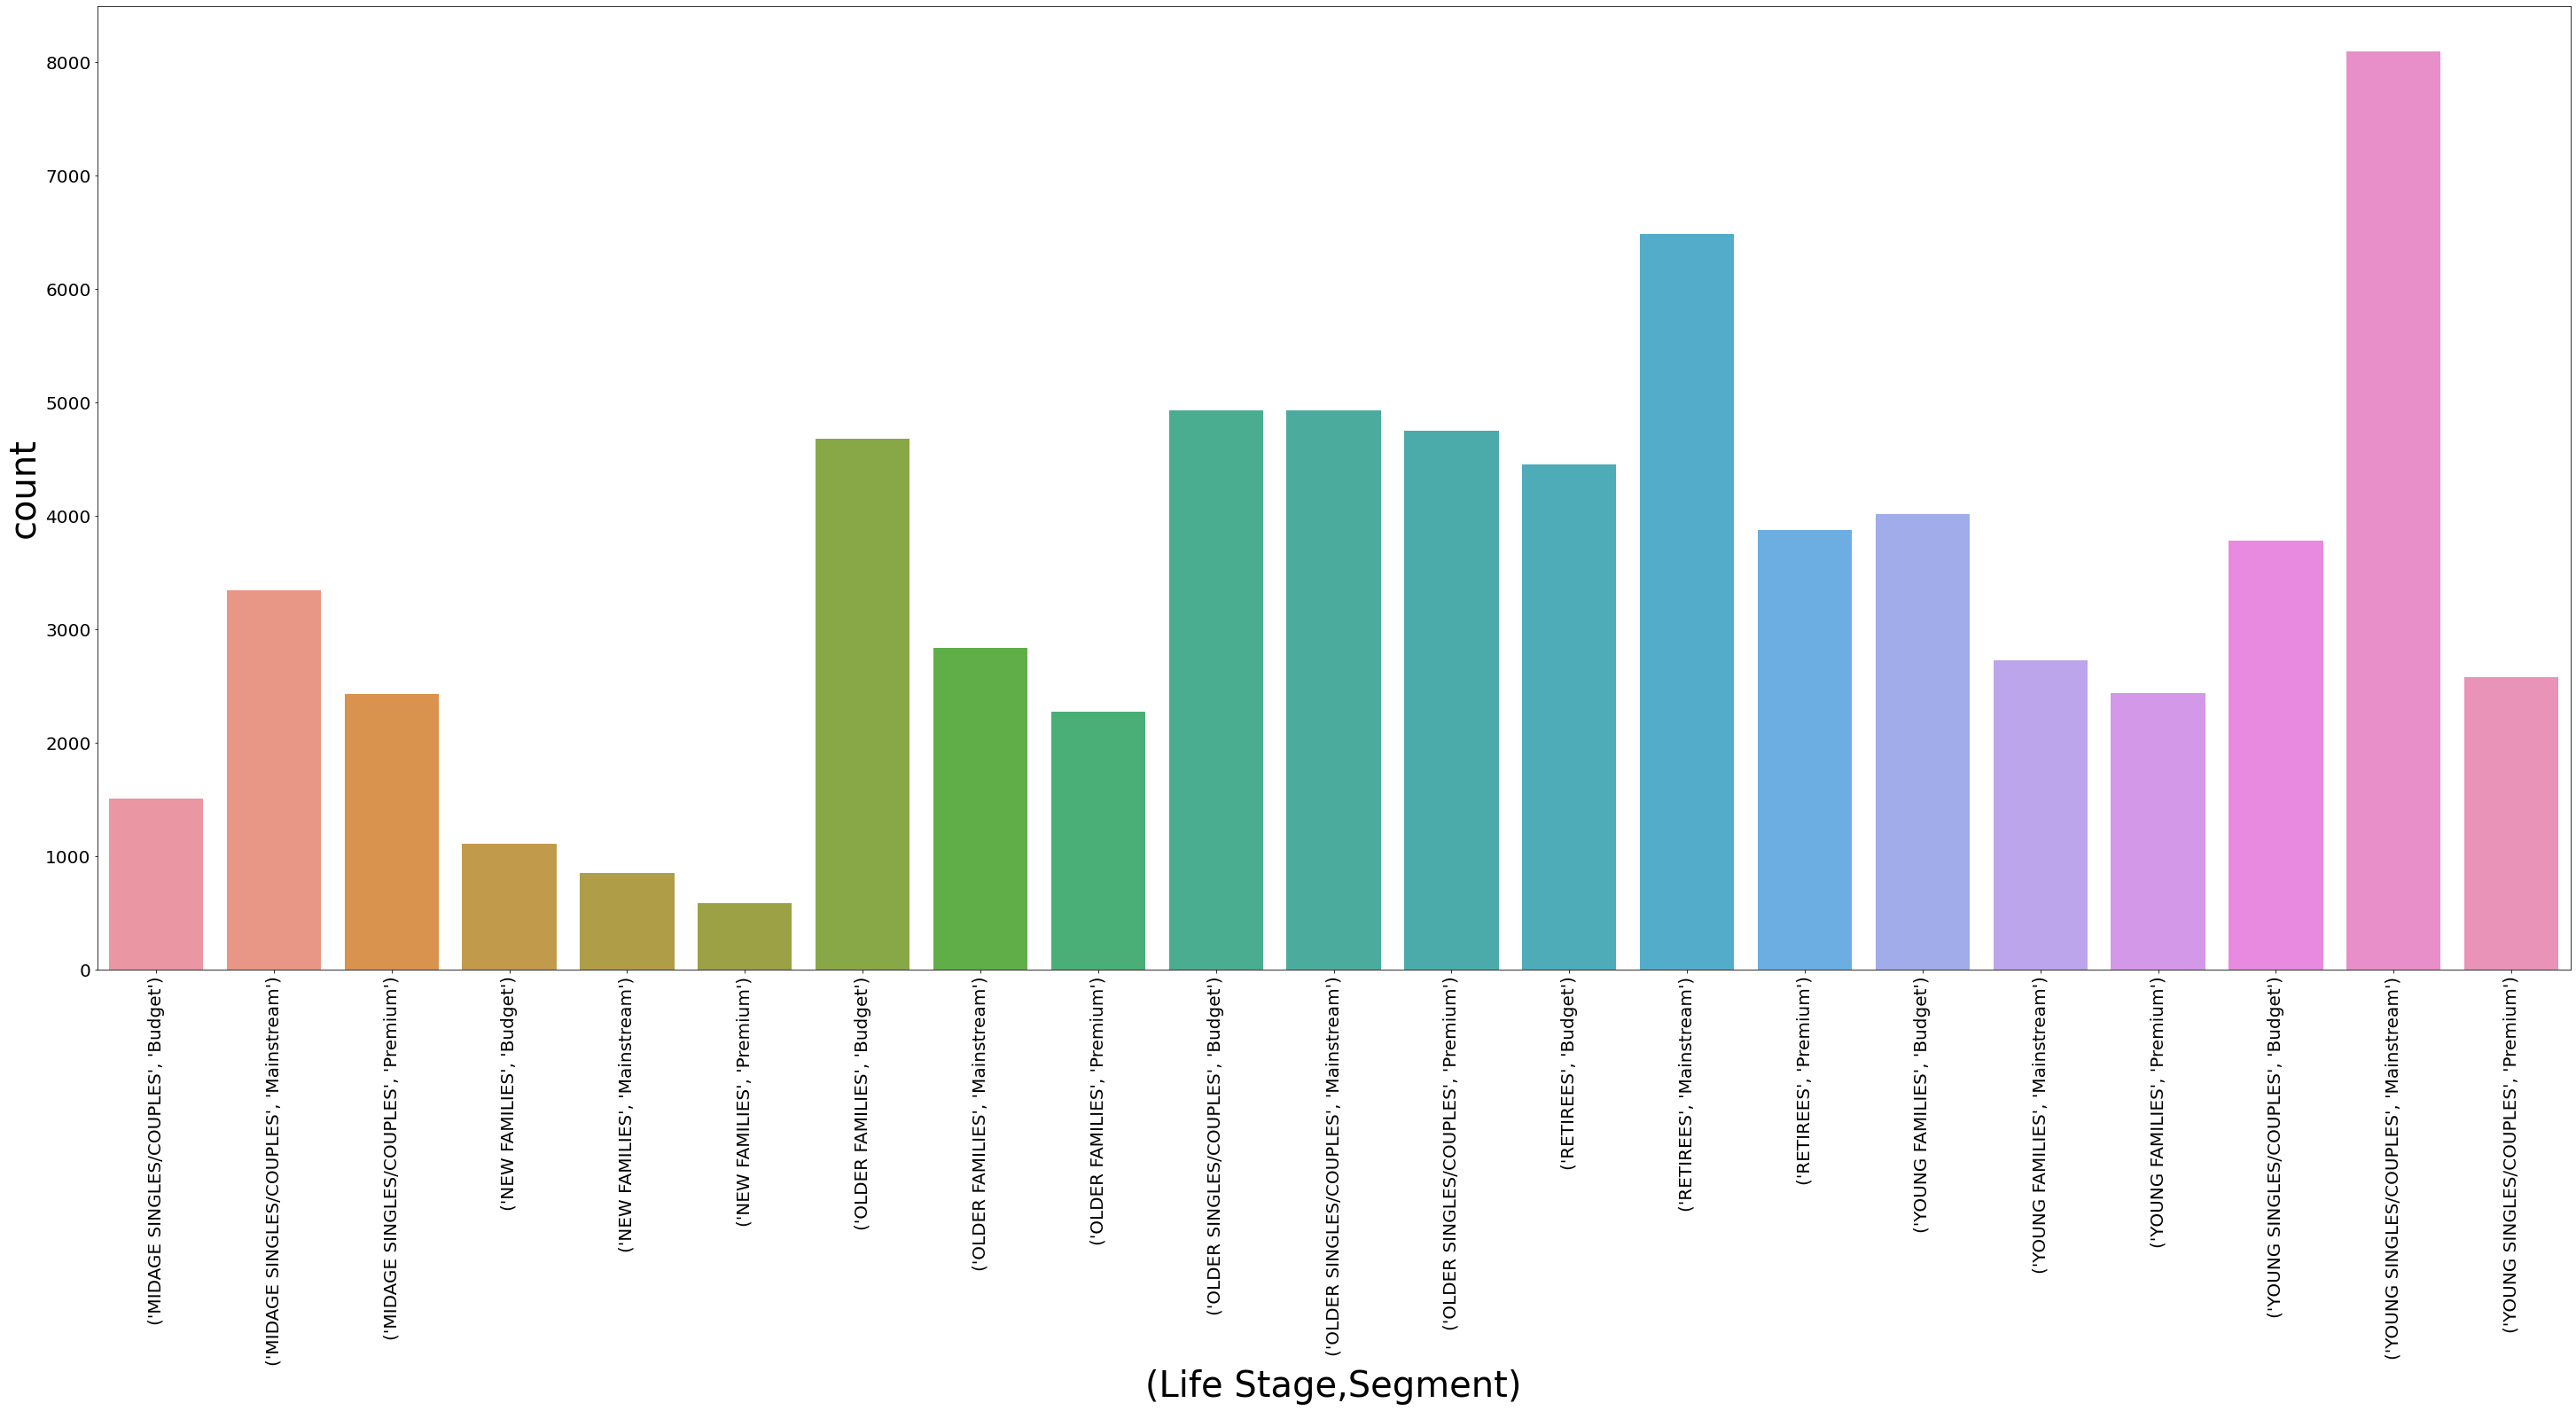

In [37]:
# For each class of Lifesize how many classes of customers are there? like premium,mainstream,budget...
cust["count"]=1
comb1=cust[["LIFESTAGE","PREMIUM_CUSTOMER","count"]].pivot_table(index=["LIFESTAGE","PREMIUM_CUSTOMER"],aggfunc=sum)

fig,ax=plt.subplots(figsize=(50,20))
sns.barplot(x=comb1.index,y=comb1["count"])
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel("(Life Stage,Segment)",fontsize=40)
ax.set_ylabel("count",fontsize=40)

### Joining the 2 dataframes

In [38]:
transc

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm,BRAND
0,2018-10-17,1,1000,1,5,natural chip compny seasalt,2,6.0,175,natural
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,175,ccs
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,170,smiths
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion,5,15.0,175,smiths
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili,3,13.8,150,kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream,2,10.8,175,kettle
264832,2018-08-13,272,272358,270154,74,tostitos splash of lime,1,4.4,175,tostitos
264833,2018-11-06,272,272379,270187,51,doritos mexicana,2,8.8,170,doritos
264834,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno,2,7.8,150,doritos


In [39]:
cust.drop(columns=["count"],inplace=True)
cust

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [40]:
data=pd.merge(transc,cust,on="LYLTY_CARD_NBR",how="left")
data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chip compny seasalt,2,6.0,175,natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,kettle sweet chilli and sour cream,2,10.8,175,kettle,YOUNG SINGLES/COUPLES,Premium
246736,2018-08-13,272,272358,270154,74,tostitos splash of lime,1,4.4,175,tostitos,YOUNG SINGLES/COUPLES,Premium
246737,2018-11-06,272,272379,270187,51,doritos mexicana,2,8.8,170,doritos,YOUNG SINGLES/COUPLES,Premium
246738,2018-12-27,272,272379,270188,42,doritos corn chip mexican jalapeno,2,7.8,150,doritos,YOUNG SINGLES/COUPLES,Premium


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246740 entries, 0 to 246739
Data columns (total 12 columns):
DATE                246740 non-null datetime64[ns]
STORE_NBR           246740 non-null int64
LYLTY_CARD_NBR      246740 non-null int64
TXN_ID              246740 non-null int64
PROD_NBR            246740 non-null int64
PROD_NAME           246740 non-null object
PROD_QTY            246740 non-null int64
TOT_SALES           246740 non-null float64
Pkg_size_grm        246740 non-null int32
BRAND               246740 non-null object
LIFESTAGE           246740 non-null object
PREMIUM_CUSTOMER    246740 non-null object
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5), object(4)
memory usage: 23.5+ MB


In [42]:
data.to_csv("Merged_Data.csv")

In [43]:
data[data["LYLTY_CARD_NBR"]==230078]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
30590,2019-05-17,230,230078,232430,68,pringles chicken salt crips,4,14.8,134,pringles,OLDER FAMILIES,Budget
48810,2018-07-18,230,230078,232416,7,smiths crinkle original,2,11.4,330,smiths,OLDER FAMILIES,Budget
48811,2018-07-31,230,230078,232417,85,rrd honey soy chicken,2,6.0,165,red,OLDER FAMILIES,Budget
48812,2018-09-26,230,230078,232418,90,tostitos smoked chipotle,2,8.8,175,tostitos,OLDER FAMILIES,Budget
48813,2018-09-29,230,230078,232419,1,smiths crinkle cut chips barbecue,2,5.8,170,smiths,OLDER FAMILIES,Budget
48814,2018-10-25,230,230078,232420,2,cobs popd sour crm &chives chips,2,7.6,110,cobs,OLDER FAMILIES,Budget
48815,2018-10-29,230,230078,232421,87,infuzions bbq rib prawn crackers,2,7.6,110,infuzions,OLDER FAMILIES,Budget
48816,2018-11-18,230,230078,232422,79,smiths chip thinly cutsalt/vinegr,2,6.0,175,smiths,OLDER FAMILIES,Budget
48817,2018-12-23,230,230078,232424,17,kettle sensations bbq&maple,2,9.2,150,kettle,OLDER FAMILIES,Budget
48818,2019-01-09,230,230078,232425,63,kettle swt pot sea salt,2,8.4,135,kettle,OLDER FAMILIES,Budget


#### TOT_SALES --> Expenditure

## Data Analysis

In [45]:
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chip compny seasalt,2,6.0,175,natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget


#### Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is....

In [46]:
q1=data[['LIFESTAGE','PREMIUM_CUSTOMER','TOT_SALES']].pivot_table(index=['PREMIUM_CUSTOMER','LIFESTAGE'],aggfunc=sum)
q1.sort_values('TOT_SALES',ascending=False,inplace=True)

Text(0, 0.5, 'Sum of TOT_SALES')

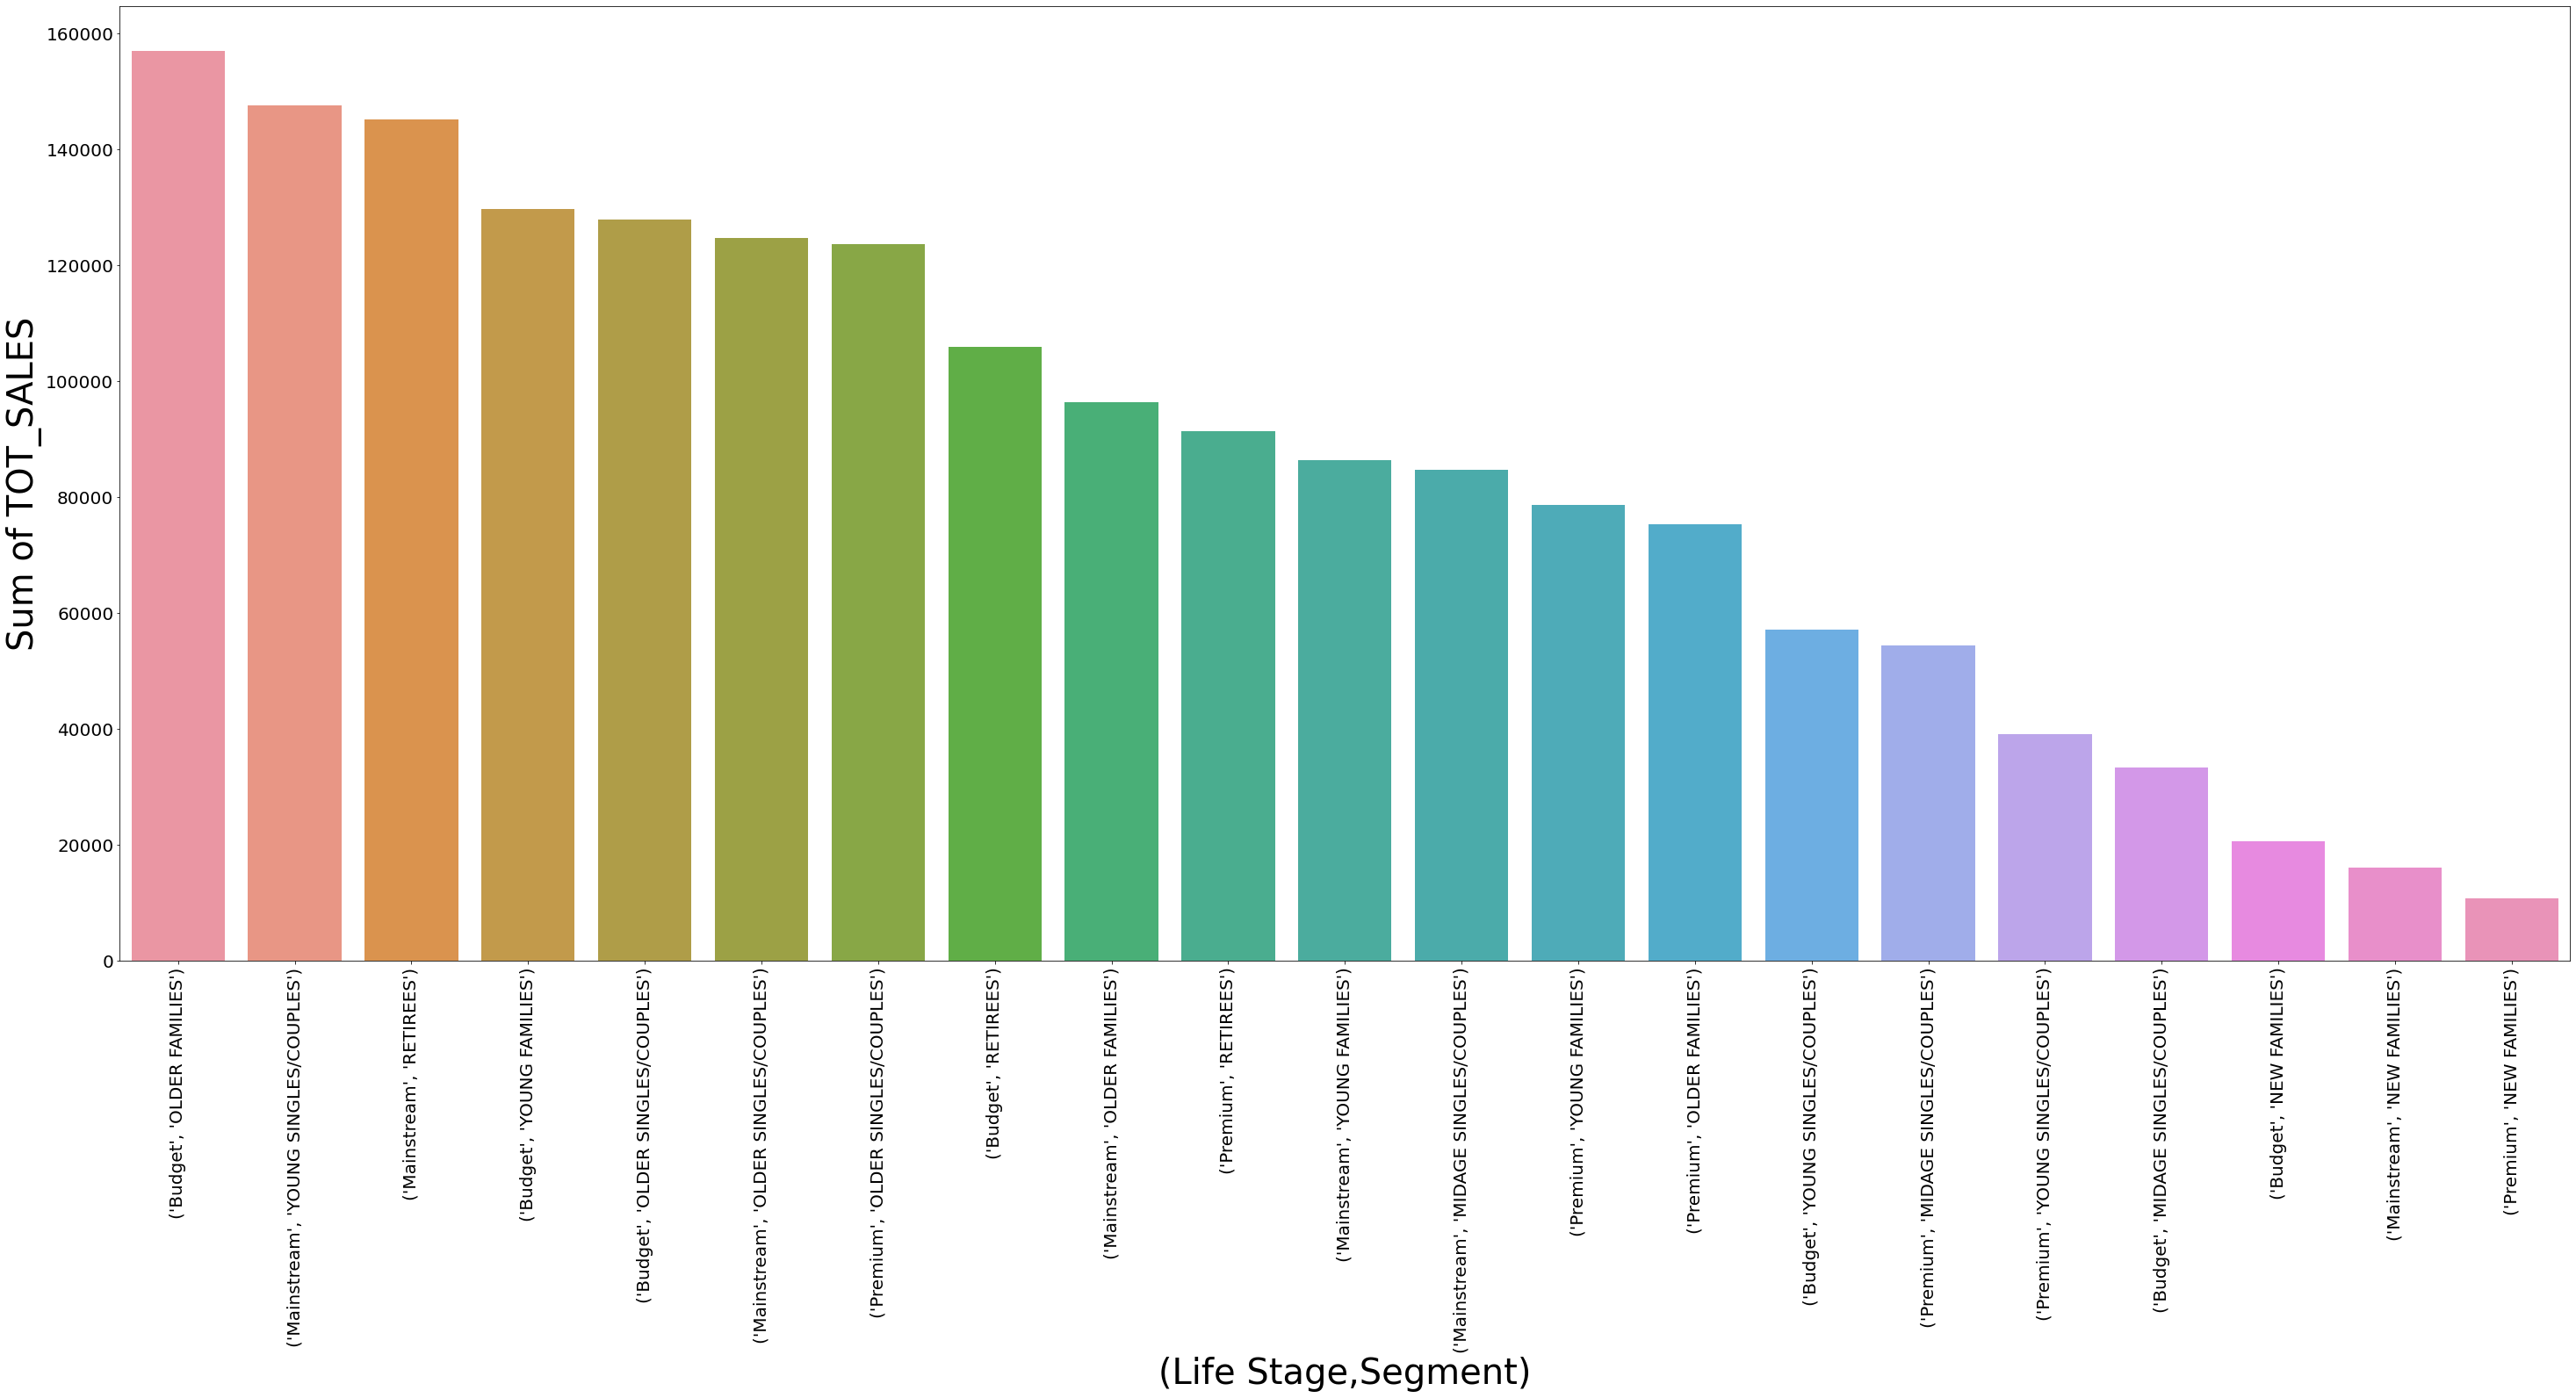

In [47]:
fig,ax=plt.subplots(figsize=(50,20))
sns.barplot(x=q1.index,y=q1["TOT_SALES"])
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel("(Life Stage,Segment)",fontsize=40)
ax.set_ylabel("Sum of TOT_SALES",fontsize=40)

#### How many customers are in each segment?

Text(0, 0.5, 'Count')

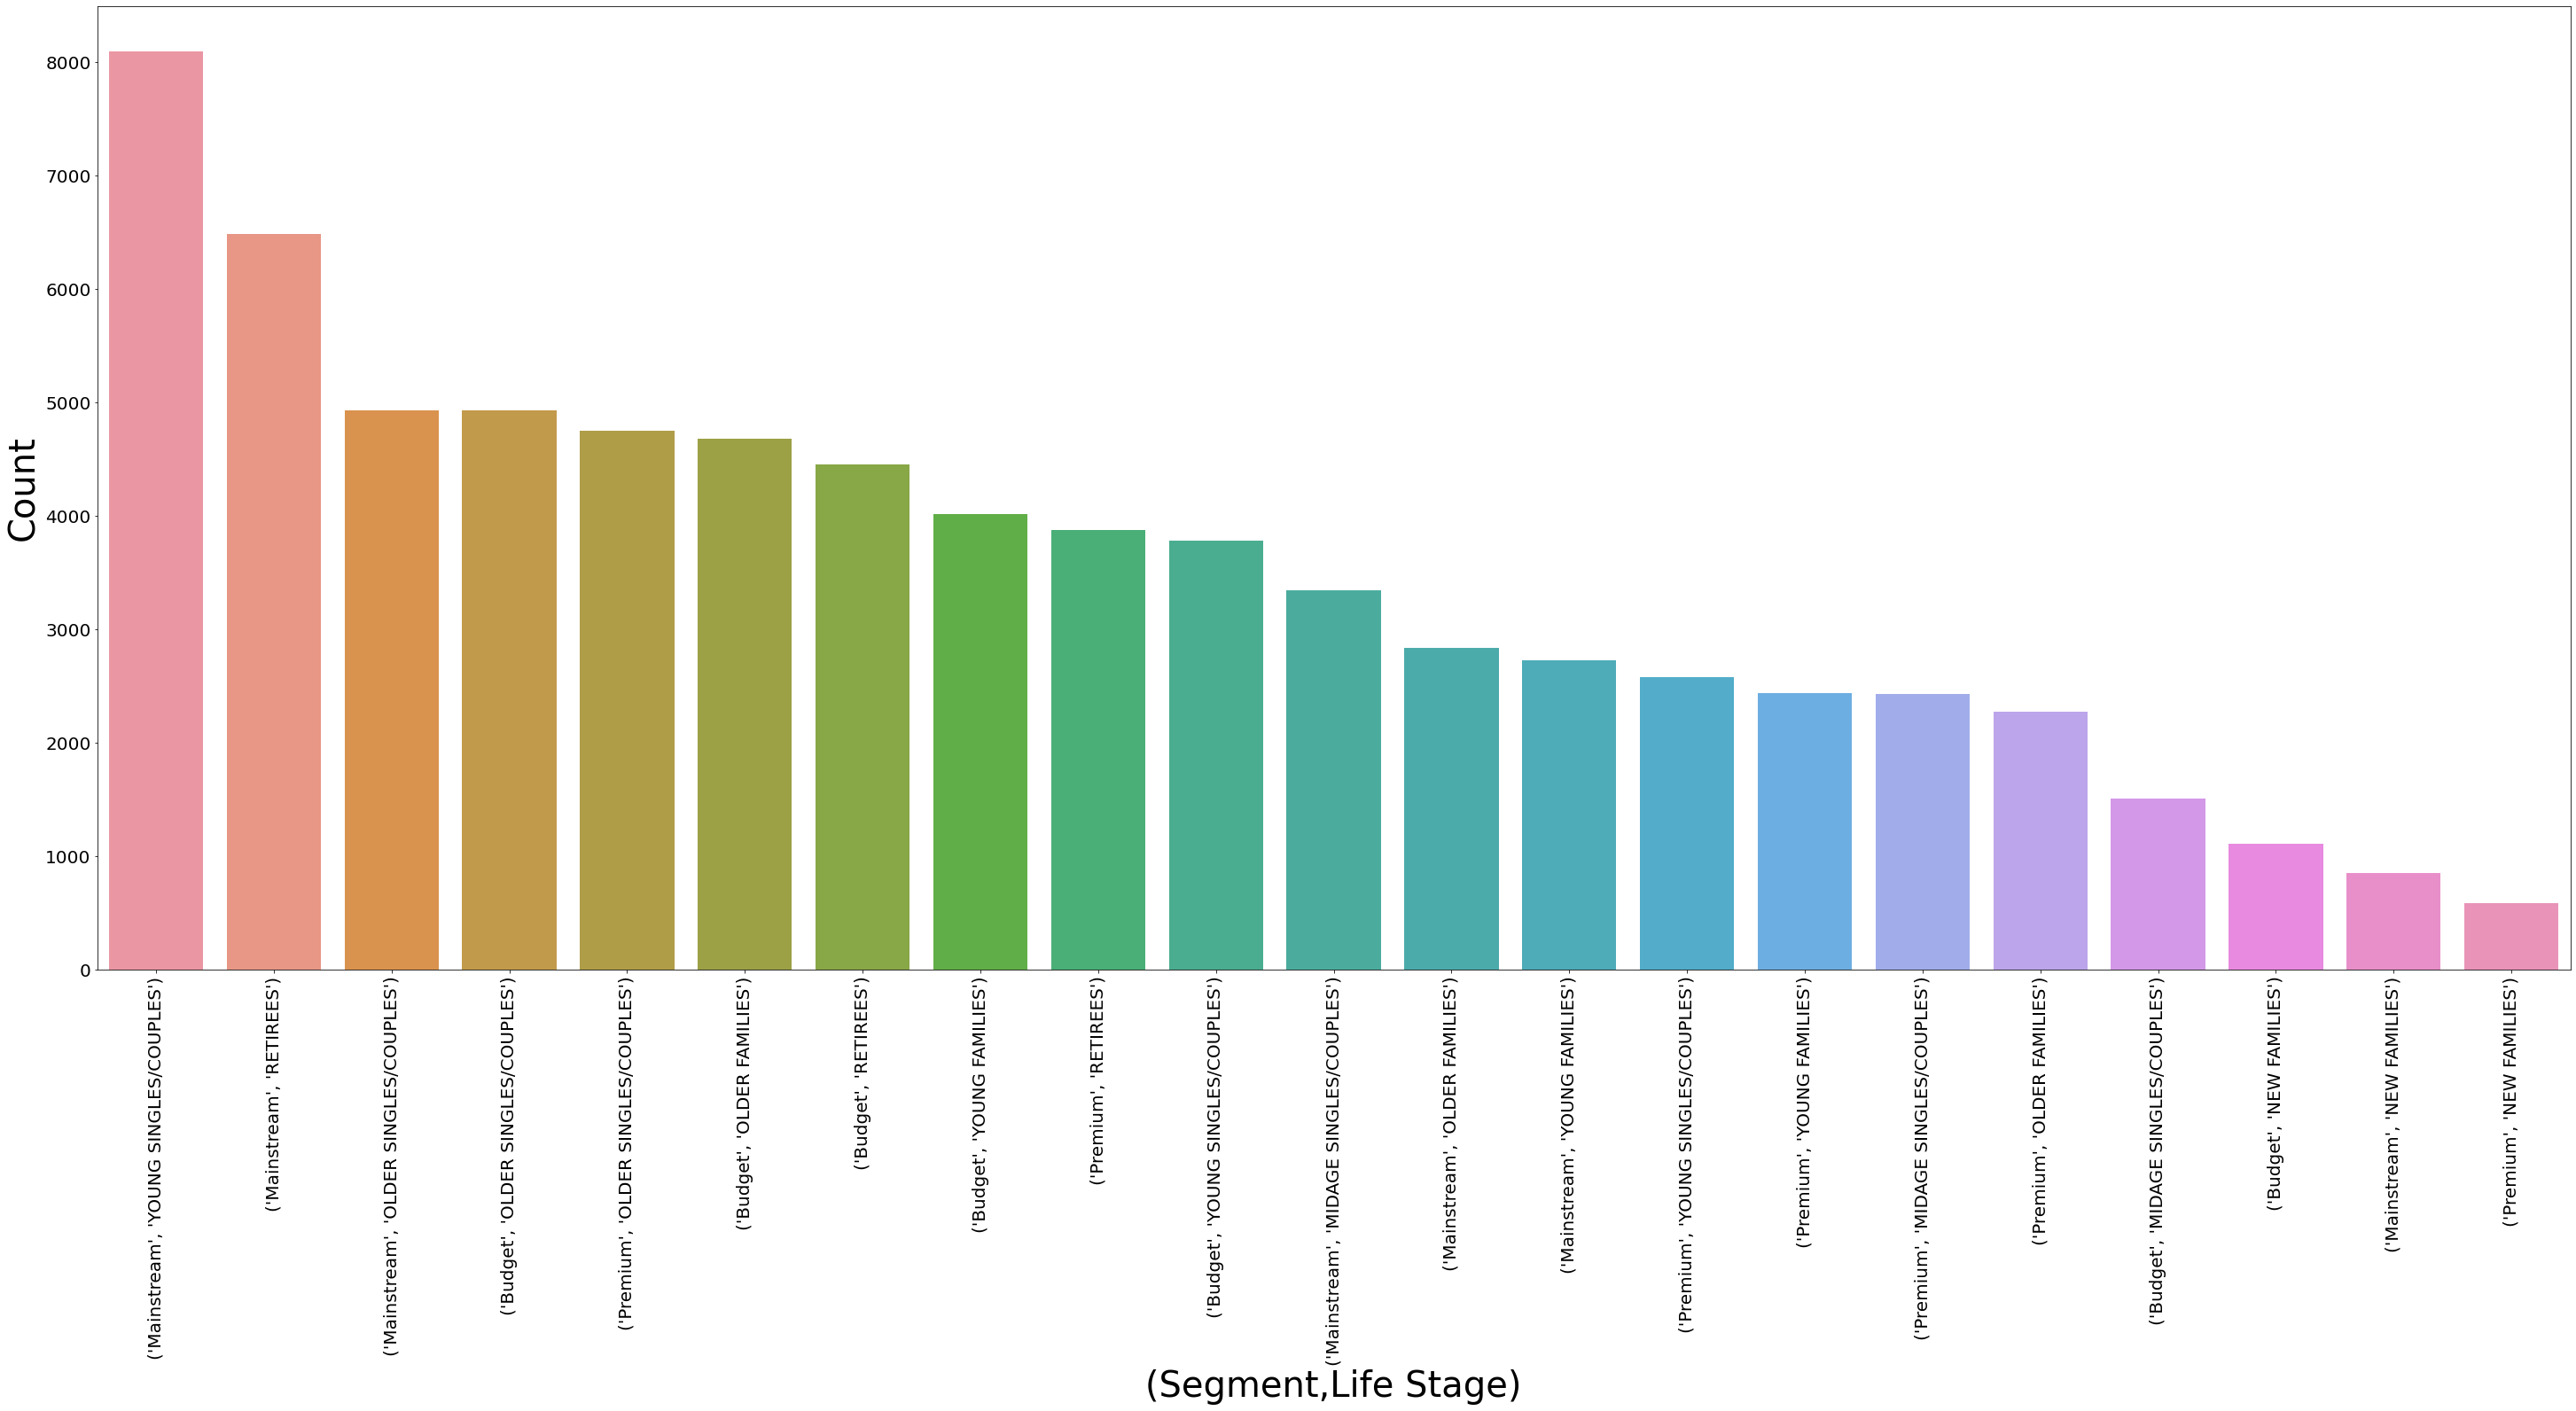

In [48]:
cust['count']=1
comb2=cust[["LIFESTAGE","PREMIUM_CUSTOMER","count"]].pivot_table(index=["PREMIUM_CUSTOMER","LIFESTAGE"],aggfunc=sum)
comb2.sort_values('count',ascending=False,inplace=True)

fig,ax=plt.subplots(figsize=(50,20))
sns.barplot(x=comb2.index,y=comb2["count"])
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel("(Segment,Life Stage)",fontsize=40)
ax.set_ylabel("Count",fontsize=40)

#### Average no.of units per customers...

In [49]:
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,Pkg_size_grm,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,natural chip compny seasalt,2,6.0,175,natural,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,ccs nacho cheese,3,6.3,175,ccs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,smiths crinkle cut chips chicken,2,2.9,170,smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,smiths chip thinly s/cream&onion,5,15.0,175,smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,kettle tortilla chpshny&jlpno chili,3,13.8,150,kettle,MIDAGE SINGLES/COUPLES,Budget


In [50]:
t1=data[['LIFESTAGE','PREMIUM_CUSTOMER','PROD_QTY']].pivot_table(index=['PREMIUM_CUSTOMER','LIFESTAGE'],aggfunc=sum)
r=data.loc[:,['LIFESTAGE','PREMIUM_CUSTOMER']]
r['count']=1
t2=r.pivot_table(index=['PREMIUM_CUSTOMER','LIFESTAGE'],aggfunc=sum)

q3=pd.merge(t1,t2,on=['PREMIUM_CUSTOMER','LIFESTAGE'],how='inner')
q3['Avg']=q3['PROD_QTY']/q3['count']
q3.sort_values('Avg',ascending=False,inplace=True)

Text(0, 0.5, 'Average')

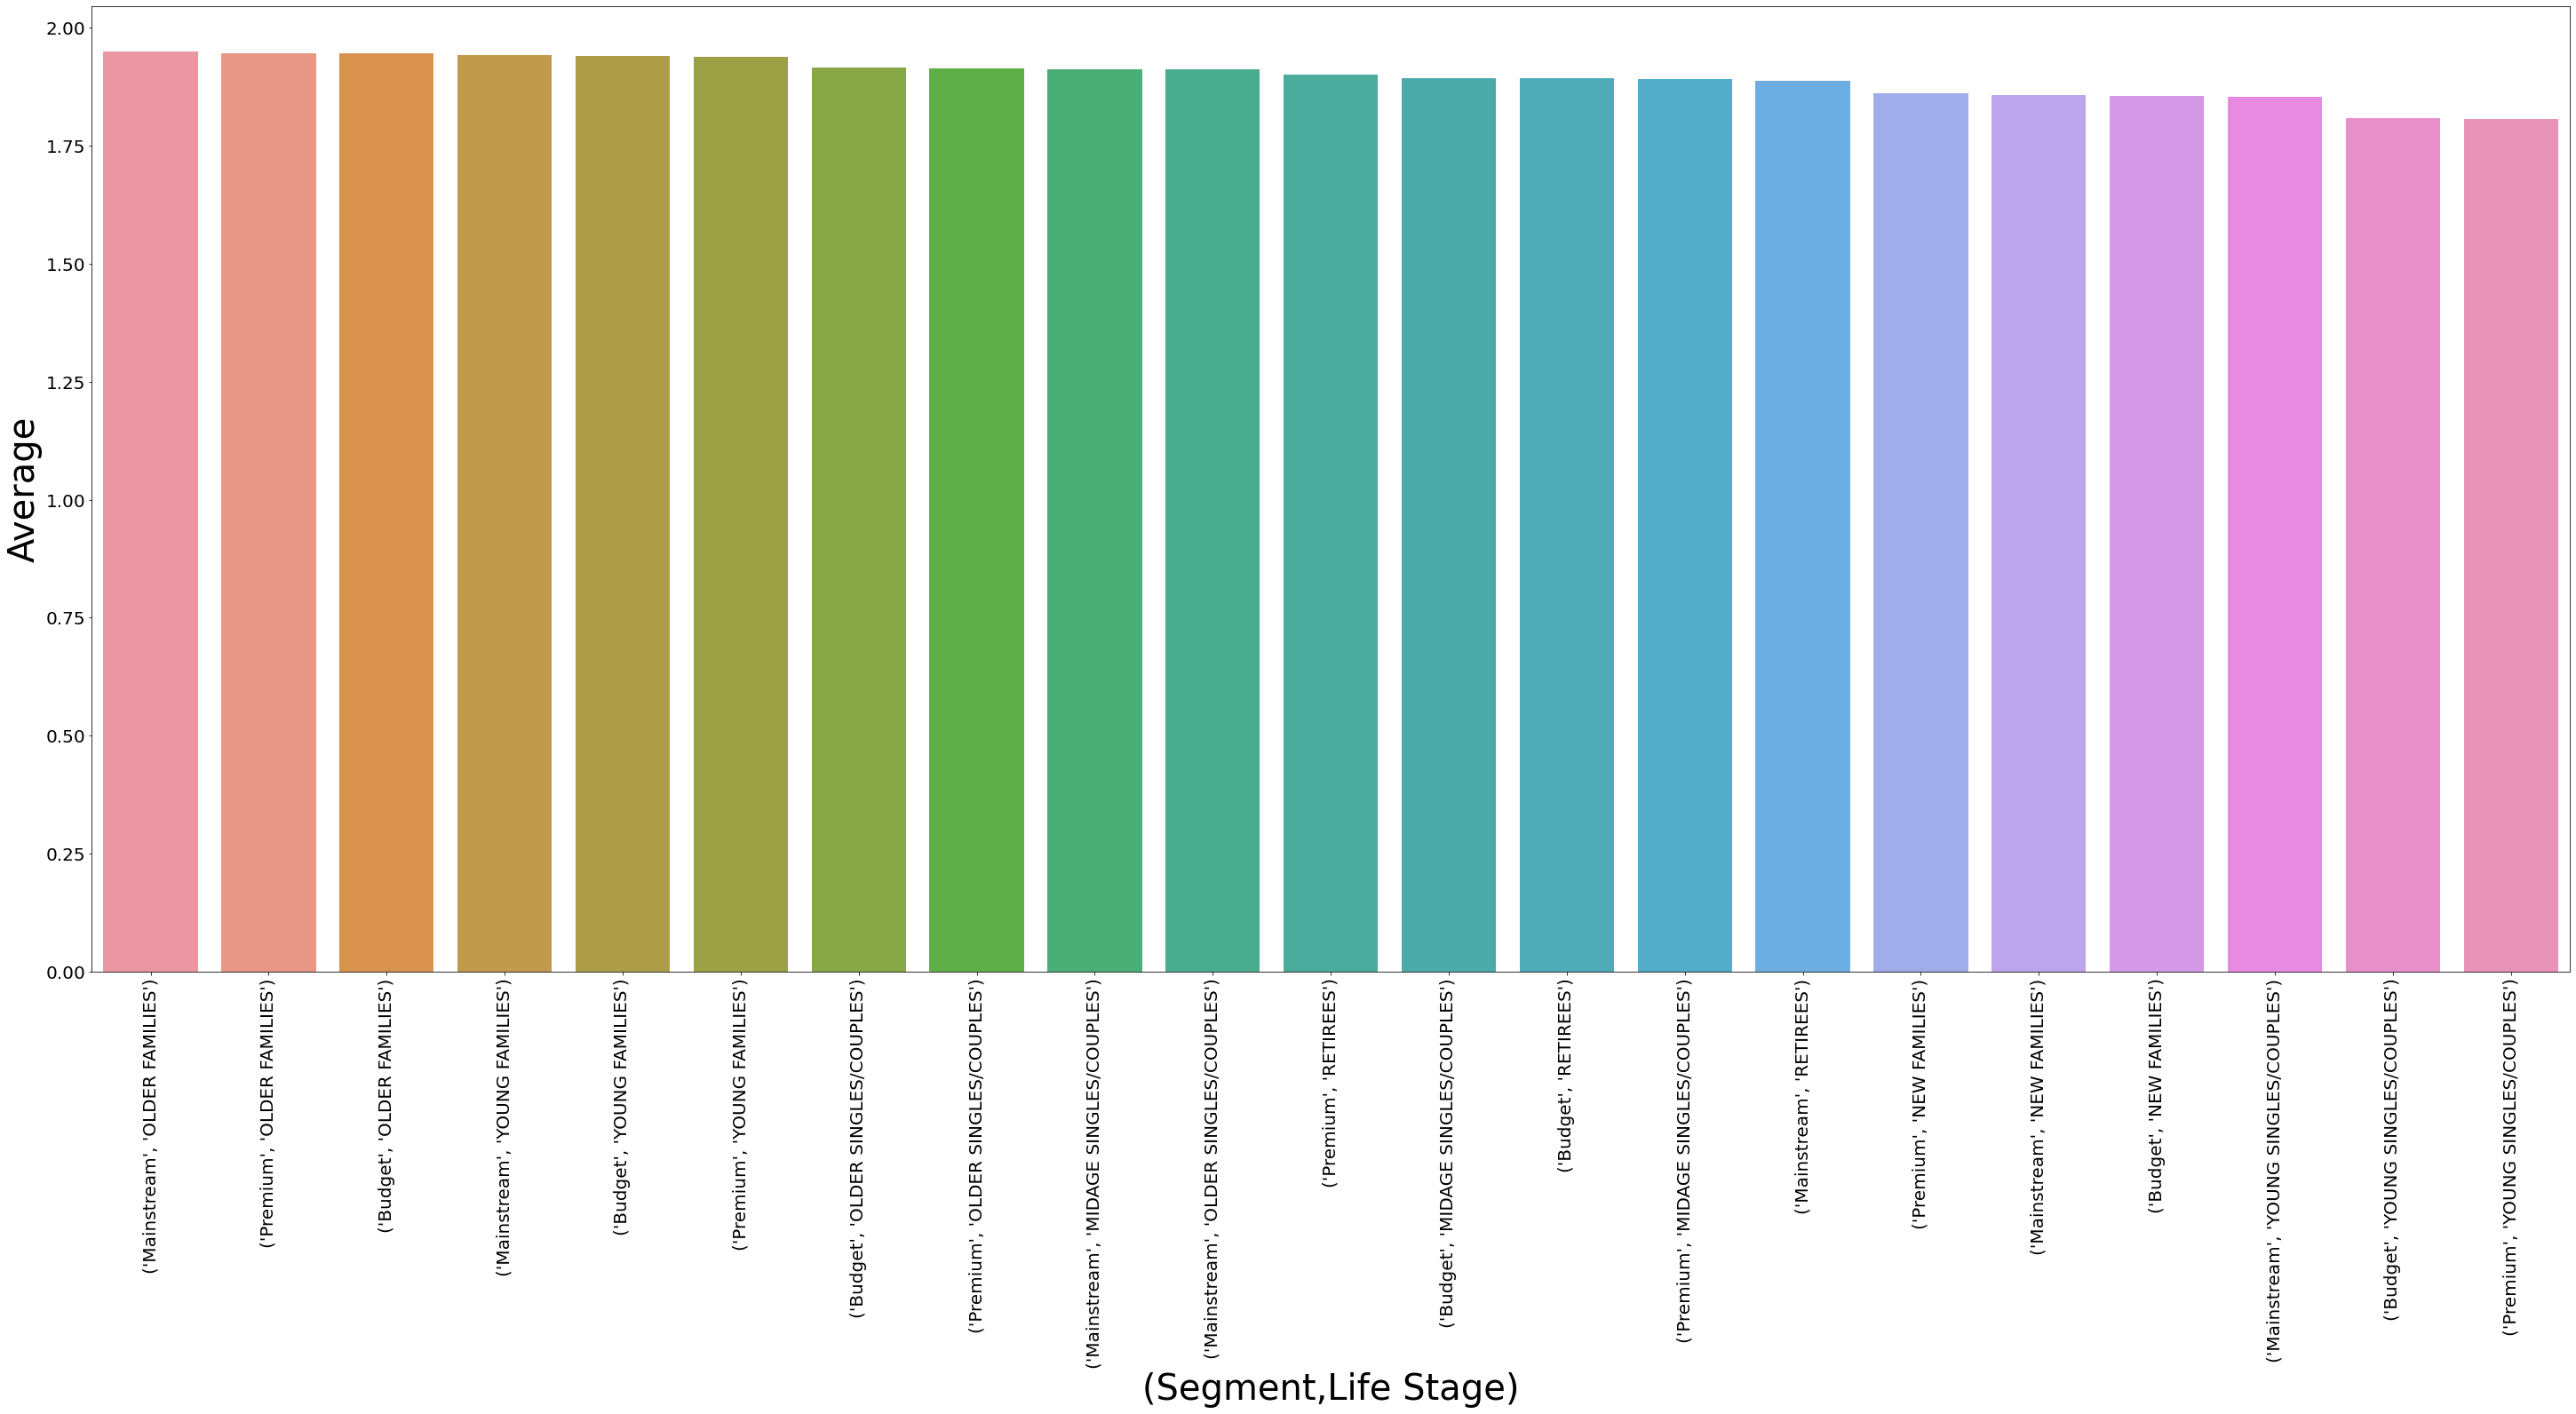

In [51]:
fig,ax=plt.subplots(figsize=(50,20))
sns.barplot(x=q3.index,y=q3["Avg"])
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel("(Segment,Life Stage)",fontsize=40)
ax.set_ylabel("Average",fontsize=40)

#### Average sales per customer....

Text(0, 0.5, 'Average Price per Unit')

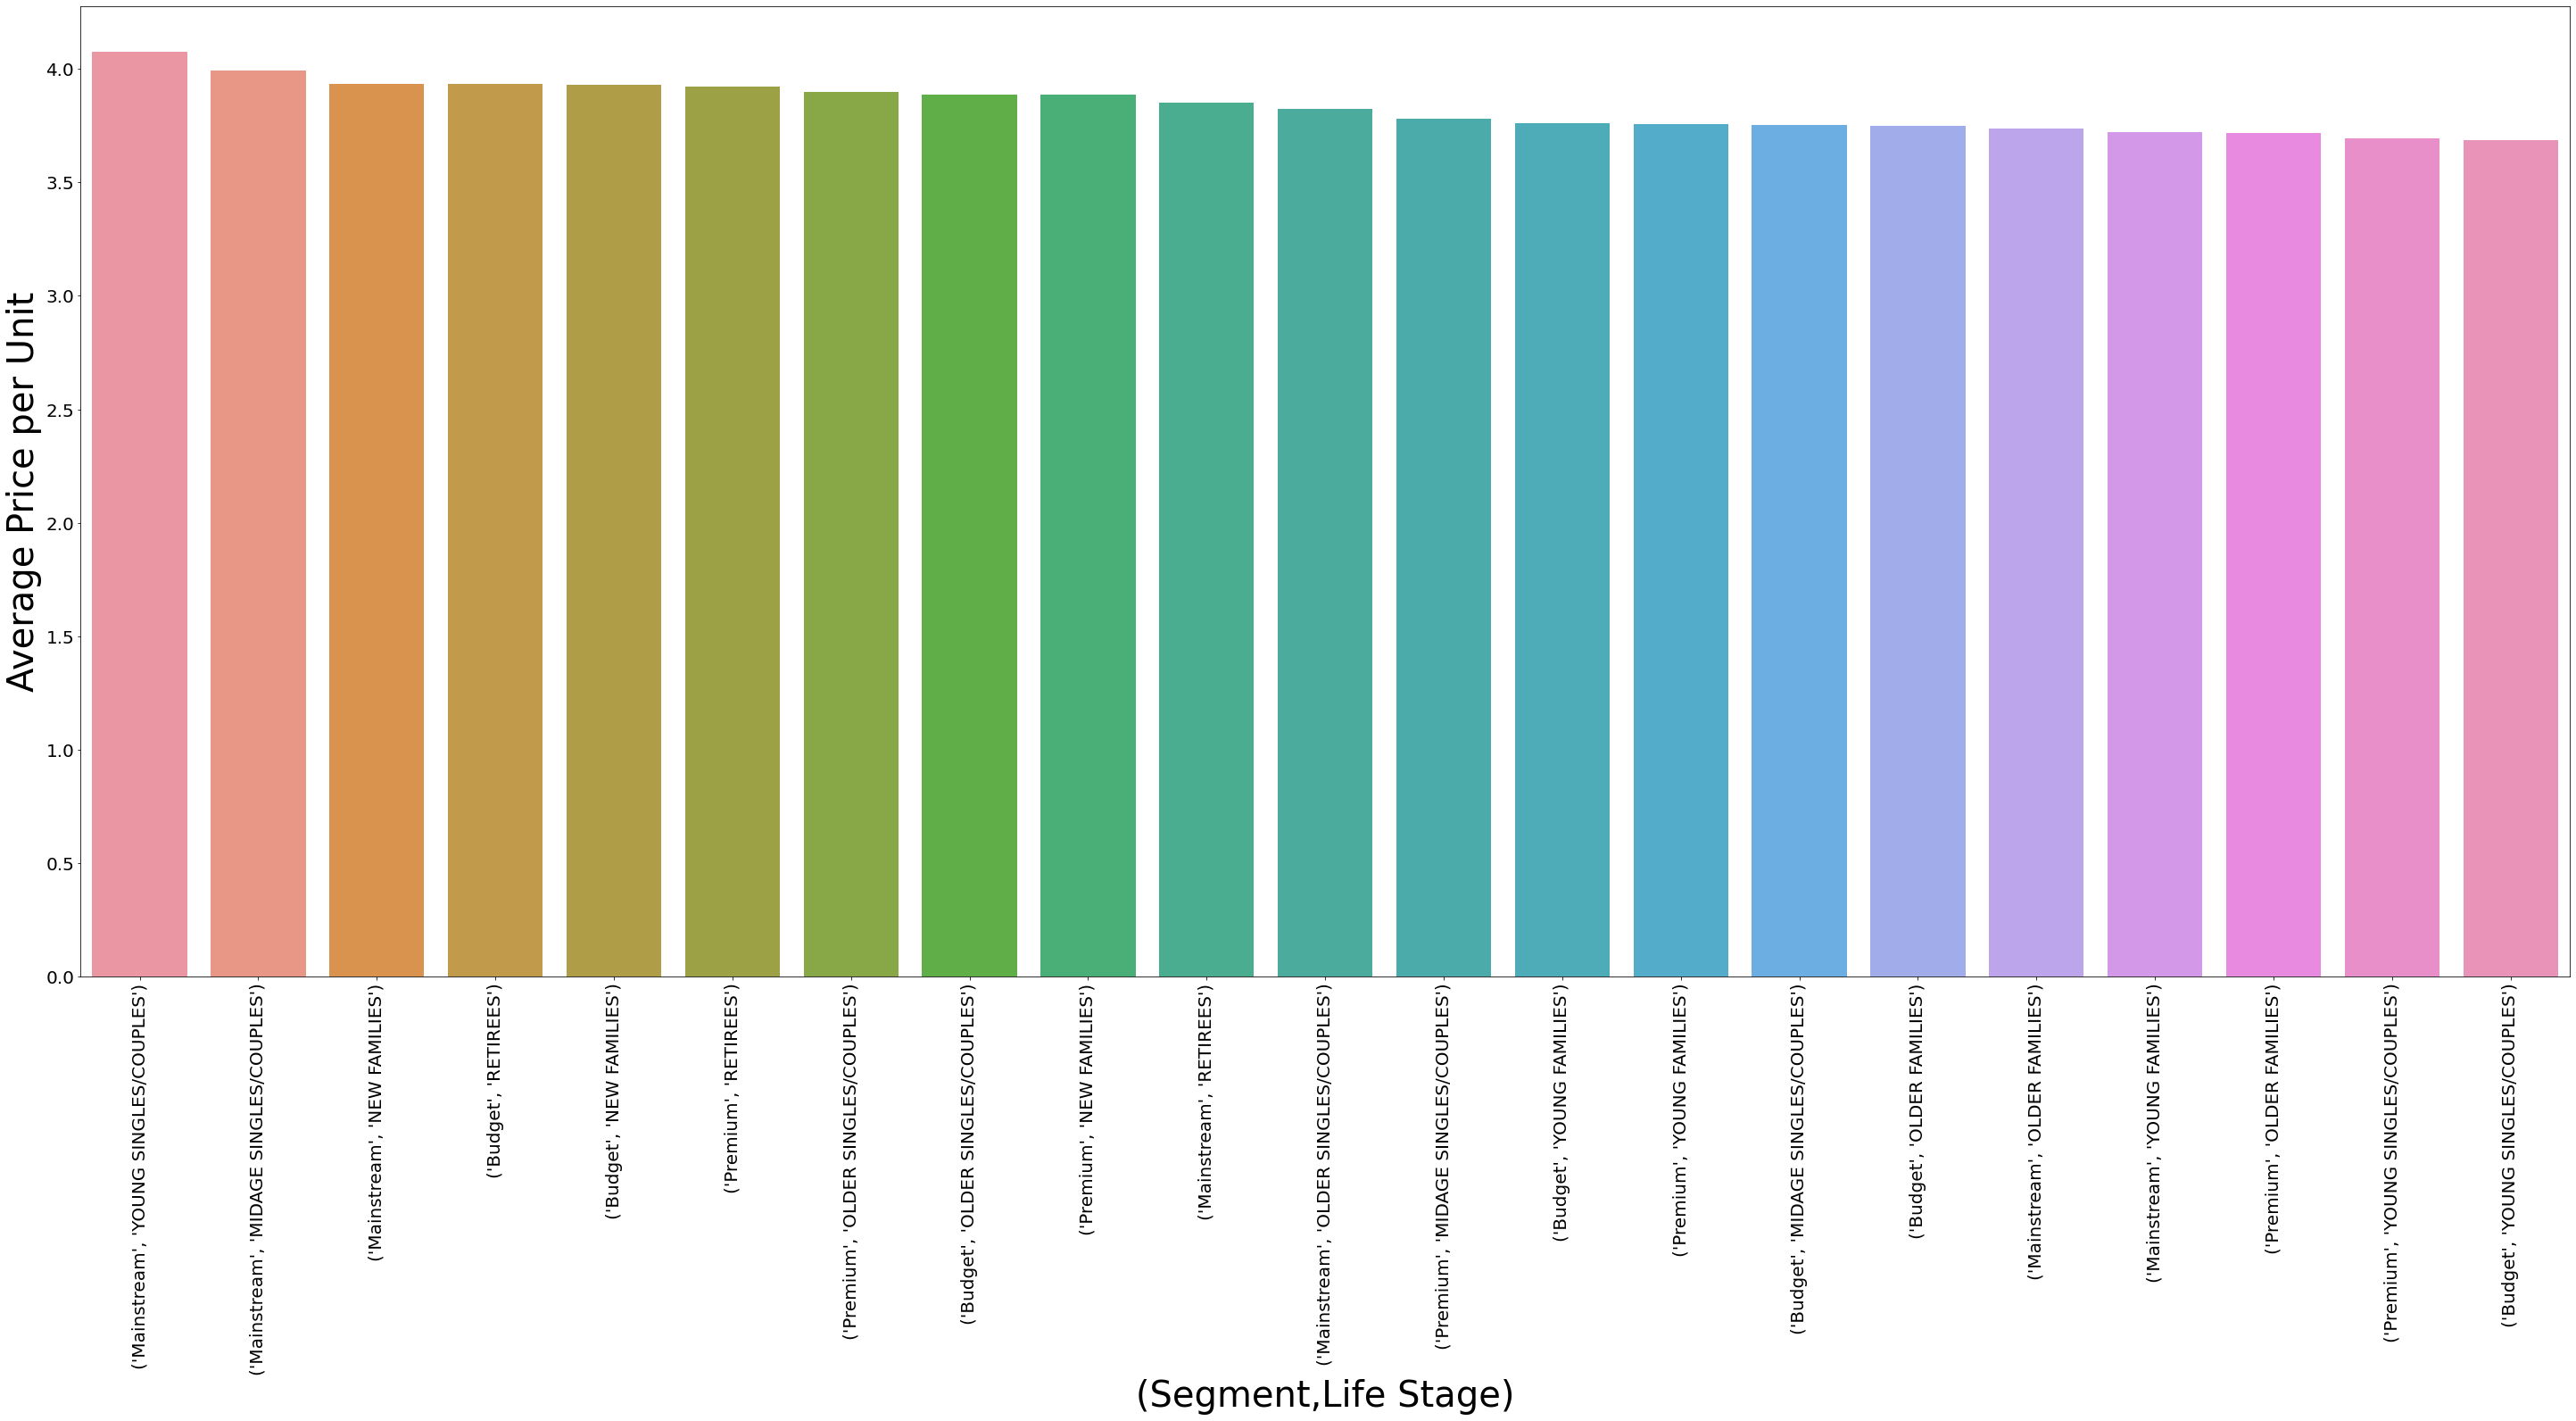

In [52]:
q4=pd.merge(q1,q3,on=['PREMIUM_CUSTOMER','LIFESTAGE'],how='inner')
q4.drop(columns=['count','Avg'],inplace=True)
q4['Avg_Price_per_unit']=q4['TOT_SALES']/q4['PROD_QTY']
q4.sort_values('Avg_Price_per_unit',ascending=False,inplace=True)

fig,ax=plt.subplots(figsize=(50,20))
sns.barplot(x=q4.index,y=q4["Avg_Price_per_unit"])
plt.xticks(rotation=90,fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel("(Segment,Life Stage)",fontsize=40)
ax.set_ylabel("Average Price per Unit",fontsize=40)

#### Comparing Avg. spend value of Mainstream VS (Budget,Premium) MIDAGE Singles/Couples
#### Performing an Independent T-TEST

In [53]:
from scipy.stats import ttest_ind
Main_Mid_SC=data[(data['PREMIUM_CUSTOMER']=='Mainstream') & (data['LIFESTAGE']=='MIDAGE SINGLES/COUPLES')]['TOT_SALES']
Bud_Mid_SC=data[(data['PREMIUM_CUSTOMER']=='Budget') & (data['LIFESTAGE']=='MIDAGE SINGLES/COUPLES')]['TOT_SALES']
Prem_Mid_SC=data[(data['PREMIUM_CUSTOMER']=='Premium') & (data['LIFESTAGE']=='MIDAGE SINGLES/COUPLES')]['TOT_SALES']

# Conducting the Independent t-test between the different groups
test1=ttest_ind(Main_Mid_SC,Bud_Mid_SC)
print('*************')
print(test1)
test2=ttest_ind(Main_Mid_SC,Prem_Mid_SC)
print('*************')
print(test2)
print('*************')

*************
Ttest_indResult(statistic=12.421324519390907, pvalue=2.9261775109787517e-35)
*************
Ttest_indResult(statistic=13.241691707555207, pvalue=7.617435190634637e-40)
*************


In [54]:
from scipy.stats import ttest_ind
Main_Y_SC=data[(data['PREMIUM_CUSTOMER']=='Mainstream') & (data['LIFESTAGE']=='YOUNG SINGLES/COUPLES')]['TOT_SALES']
Bud_Y_SC=data[(data['PREMIUM_CUSTOMER']=='Budget') & (data['LIFESTAGE']=='YOUNG SINGLES/COUPLES')]['TOT_SALES']
Prem_Y_SC=data[(data['PREMIUM_CUSTOMER']=='Premium') & (data['LIFESTAGE']=='YOUNG SINGLES/COUPLES')]['TOT_SALES']

# Conducting the Independent t-test between the different groups
test3=ttest_ind(Main_Y_SC,Bud_Y_SC)
print('*************')
print(test3)
test4=ttest_ind(Main_Y_SC,Prem_Y_SC)
print('*************')
print(test4)
print('*************')

*************
Ttest_indResult(statistic=27.22814256468533, pvalue=3.724927303819137e-161)
*************
Ttest_indResult(statistic=23.49376558153048, pvalue=9.18185352339897e-121)
*************


#### The p-value is not below the significance level....
#### So we accept the Null Hypothesis that the unit price for mainstream, young and mid-age singles and couples ARE NOT significantly higher than that of budget or premium, young and midage singles and couples.

# Deep dive into Mainstream, Young singles/couples
## Performing an Affinity/Apriori Analysis

In [69]:
# For Brand of Chips and Size of Chips 
prem_brand=data[['PREMIUM_CUSTOMER','BRAND']]

In [84]:
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
te=TransactionEncoder()
pb_array=np.array(prem_brand)
te_pb=te.fit(pb_array).transform(pb_array)
te_pb

array([[False, False,  True, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [85]:
pb_df=pd.DataFrame(te_pb,columns=te.columns_)
pb_df

,Budget,Mainstream,Premium,burger rings,ccs,cheetos,cheezels,cobs,doritos,french fries,...,natural,pringles,red,smiths,sunbites,thins,tostitos,twisties,tyrrells,woolworths
0,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246736,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
246737,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
246738,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [91]:
frequent_brands=apriori(pb_df,min_support=0.05,use_colnames=True)
frequent_brands

,support,itemsets
0,0.351633,(Budget)
1,0.385195,(Mainstream)
2,0.263172,(Premium)
3,0.102229,(doritos)
4,0.057555,(infuzions)
5,0.167334,(kettle)
6,0.101735,(pringles)
7,0.066147,(red)
8,0.123016,(smiths)
9,0.057044,(thins)


So here the "Mainstream" segment customers preder to buy the Brand "Kettle".
But the support value is really low but it gives us a freq of almost 15000.....is that a considerable amount to take into consideration?
So....

## Association Rule Mining for (Customer segment,Brand)

In [96]:
from mlxtend.frequent_patterns import association_rules
rules=association_rules(frequent_brands,metric='confidence',min_threshold=0.05)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Budget),(kettle),0.351633,0.167334,0.057364,0.163136,0.974912,-0.001476,0.994984
1,(kettle),(Budget),0.167334,0.351633,0.057364,0.342811,0.974912,-0.001476,0.986576
2,(kettle),(Mainstream),0.167334,0.385195,0.066560,0.397767,1.032638,0.002104,1.020876
3,(Mainstream),(kettle),0.385195,0.167334,0.066560,0.172795,1.032638,0.002104,1.006602


Mainstream =======> Kettle 
Gives us a Confidence of 0.17...which means that out of all the transactions which contain "Mainstream" segment customer....17% of the time a chip beonging to brand "Kettle" is purchased.

In [97]:
# For Lifestage and Brand 
lifestag_brand=data[['LIFESTAGE','BRAND']]

lb_array=np.array(lifestag_brand)
te_lb=te.fit(lb_array).transform(lb_array)
te_lb

lb_df=pd.DataFrame(te_lb,columns=te.columns_)
lb_df

,MIDAGE SINGLES/COUPLES,NEW FAMILIES,OLDER FAMILIES,OLDER SINGLES/COUPLES,RETIREES,YOUNG FAMILIES,YOUNG SINGLES/COUPLES,burger rings,ccs,cheetos,...,natural,pringles,red,smiths,sunbites,thins,tostitos,twisties,tyrrells,woolworths
0,False,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246736,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
246737,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246738,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [98]:
frequent_brands_ls=apriori(lb_df,min_support=0.05,use_colnames=True)
frequent_brands_ls

,support,itemsets
0,0.094829,(MIDAGE SINGLES/COUPLES)
1,0.183019,(OLDER FAMILIES)
2,0.205856,(OLDER SINGLES/COUPLES)
3,0.188178,(RETIREES)
4,0.164116,(YOUNG FAMILIES)
5,0.137671,(YOUNG SINGLES/COUPLES)
6,0.102229,(doritos)
7,0.057555,(infuzions)
8,0.167334,(kettle)
9,0.101735,(pringles)


## Association Rule Mining for (Lifestage,Brand)

In [106]:
rules_ls=association_rules(frequent_brands_ls,metric='confidence',min_threshold=0.01)
rules_ls

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Even with a Threshold Confidence of 0.01 we are not able generate any rules.....

## Now for Packet size and Customer Segment

In [111]:
# For Customer Segment and Packet Size 
prem_size=data[['PREMIUM_CUSTOMER','Pkg_size_grm']]
convert_dict = {'PREMIUM_CUSTOMER': str,
                'Pkg_size_grm': str
               }
prem_size = prem_size.astype(convert_dict)

ps_array=np.array(prem_size)
te_ps=te.fit(ps_array).transform(ps_array)
te_ps

ps_df=pd.DataFrame(te_ps,columns=te.columns_)
ps_df

,110,125,134,135,150,160,165,170,175,180,...,220,250,270,330,380,70,90,Budget,Mainstream,Premium
0,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
246736,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
246737,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
246738,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [112]:
frequent_size=apriori(ps_df,min_support=0.05,use_colnames=True)
frequent_size

,support,itemsets
0,0.090731,(110)
1,0.101735,(134)
2,0.162937,(150)
3,0.061996,(165)
4,0.080988,(170)
5,0.269069,(175)
6,0.050823,(330)
7,0.351633,(Budget)
8,0.385195,(Mainstream)
9,0.263172,(Premium)


## Association Rule Mining for (Customer Segment,Packet Size)

In [113]:
rules_ps=association_rules(frequent_size,metric='confidence',min_threshold=0.05)
rules_ps

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(150),(Budget),0.162937,0.351633,0.057473,0.352735,1.003133,0.000179,1.001702
1,(Budget),(150),0.351633,0.162937,0.057473,0.163447,1.003133,0.000179,1.000610
2,(150),(Mainstream),0.162937,0.385195,0.062766,0.385220,1.000065,0.000004,1.000041
3,(Mainstream),(150),0.385195,0.162937,0.062766,0.162947,1.000065,0.000004,1.000013
4,(175),(Budget),0.269069,0.351633,0.095619,0.355370,1.010626,0.001005,1.005796
5,(Budget),(175),0.351633,0.269069,0.095619,0.271928,1.010626,0.001005,1.003927
6,(175),(Mainstream),0.269069,0.385195,0.101901,0.378717,0.983182,-0.001743,0.989573
7,(Mainstream),(175),0.385195,0.269069,0.101901,0.264543,0.983182,-0.001743,0.993847
8,(175),(Premium),0.269069,0.263172,0.071549,0.265914,1.010418,0.000738,1.003735
9,(Premium),(175),0.263172,0.269069,0.071549,0.271872,1.010418,0.000738,1.003850


We have 2 rules here.....
Mainstream ========>150
Mainstream ========> 175
the 175 has greater overall support and confidence but....150 has greater Lift.

In [114]:
# For Lifestage and Packet Size 
lifestag_size=data[['LIFESTAGE','Pkg_size_grm']]
convert_dict = {'LIFESTAGE': str,
                'Pkg_size_grm': str
               }
lifestag_size = lifestag_size.astype(convert_dict)

ls_array=np.array(lifestag_size)
te_ls=te.fit(ls_array).transform(ls_array)
te_ls

ls_df=pd.DataFrame(te_ls,columns=te.columns_)
ls_df

,110,125,134,135,150,160,165,170,175,180,...,380,70,90,MIDAGE SINGLES/COUPLES,NEW FAMILIES,OLDER FAMILIES,OLDER SINGLES/COUPLES,RETIREES,YOUNG FAMILIES,YOUNG SINGLES/COUPLES
0,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
246736,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
246737,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
246738,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [115]:
frequent_size_ls=apriori(ls_df,min_support=0.05,use_colnames=True)
frequent_size_ls

,support,itemsets
0,0.090731,(110)
1,0.101735,(134)
2,0.162937,(150)
3,0.061996,(165)
4,0.080988,(170)
5,0.269069,(175)
6,0.050823,(330)
7,0.094829,(MIDAGE SINGLES/COUPLES)
8,0.183019,(OLDER FAMILIES)
9,0.205856,(OLDER SINGLES/COUPLES)


## Association Rule Mining for (Lifestage, Packet Size)

In [118]:
rules_ls=association_rules(frequent_size_ls,metric='confidence',min_threshold=0.00001)
rules_ls

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(175),(OLDER SINGLES/COUPLES),0.269069,0.205856,0.055151,0.204971,0.995697,-0.000238,0.998886
1,(OLDER SINGLES/COUPLES),(175),0.205856,0.269069,0.055151,0.267911,0.995697,-0.000238,0.998419
2,(175),(RETIREES),0.269069,0.188178,0.050450,0.187498,0.996388,-0.000183,0.999163
3,(RETIREES),(175),0.188178,0.269069,0.050450,0.268097,0.996388,-0.000183,0.998672


We cant seem to get enough any rules regarding the YOUNG Singles/Couples for a very low confidence threshold too....